In [1]:
import os
import gc
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision.models import efficientnet_b4, EfficientNet_B4_Weights
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score, auc, classification_report, confusion_matrix
from PIL import Image
from typing import Tuple, List, Dict
import albumentations as A
from albumentations.pytorch import ToTensorV2

os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'

In [2]:
# Configuration
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
IMG_SIZE = (380, 380)
BATCH_SIZE = 32
EPOCHS_PHASE1 = 15
EPOCHS_PHASE2 = 10
CLASS_NAMES = ['DR', 'MH', 'ODC', 'TSLN', 'DN', 'MYA', 'ARMD', 'BRVO', 'ODP', 'ODE', 'LS', 'RS', 'CSR', 'CRS']

# Set random seeds
torch.manual_seed(42)
np.random.seed(42)

def load_and_preprocess_data():
    train_labels = pd.read_csv("/kaggle/input/retinal-disease-classification/Training_Set/Training_Set/RFMiD_Training_Labels.csv")
    val_labels = pd.read_csv("/kaggle/input/retinal-disease-classification/Evaluation_Set/Evaluation_Set/RFMiD_Validation_Labels.csv")
    test_labels = pd.read_csv("/kaggle/input/retinal-disease-classification/Test_Set/Test_Set/RFMiD_Testing_Labels.csv")
    
    def process_df(df):
        selected_diseases = list(set(CLASS_NAMES) & set(df.columns))
        df = df[['ID', 'Disease_Risk'] + selected_diseases].copy()
        df['Disease_Risk'] = (df[selected_diseases].sum(axis=1) > 0).astype(int)
        return df
    
    return process_df(train_labels), process_df(val_labels), process_df(test_labels)

class RetinalDataset(Dataset):
    def __init__(self, img_dir: str, df: pd.DataFrame, transform=None, augment=False, mixup_alpha=0.4):
        self.img_dir = img_dir
        self.df = df
        self.transform = transform
        self.augment = augment
        self.mixup_alpha = mixup_alpha
        self.image_paths = [os.path.join(img_dir, f"{row['ID']}.png") for _, row in df.iterrows()]

    def __len__(self):
        return len(self.df)
        
    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB').resize((320, 320))
        
        if self.transform:
            image = self.transform(image=np.array(image))['image']
        
        labels = torch.tensor(self.df.iloc[idx][CLASS_NAMES].values, dtype=torch.float32)
        
        return image, labels

    def mixup_data(self, x: torch.Tensor, y: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        if self.mixup_alpha > 0:
            lam = np.clip(np.random.beta(self.mixup_alpha, self.mixup_alpha), 0.2, 0.8)
            batch_size = x.size()[0]

            # Make sure index tensor is on the same device as x
            index = torch.randperm(batch_size, device=x.device)
            
            mixed_x = lam * x + (1 - lam) * x[index]
            mixed_y = lam * y + (1 - lam) * y[index]
            return mixed_x, mixed_y
        return x, y

class RetinalModel(nn.Module):
    def __init__(self, num_classes: int):
        super().__init__()
        weights = EfficientNet_B4_Weights.DEFAULT
        self.backbone = efficientnet_b4(weights=weights)
        num_features = self.backbone.classifier[1].in_features
        self.backbone.classifier = nn.Identity()
        
        self.classifier = nn.Sequential(
            nn.BatchNorm1d(num_features),
            nn.Dropout(0.5),
            nn.Linear(num_features, 512),
            nn.SiLU(),
            nn.BatchNorm1d(512),
            nn.Dropout(0.5),
            nn.Linear(512, 256),
            nn.SiLU(),
            nn.Linear(256, num_classes),
        )
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.backbone(x)
        return self.classifier(x)

class FocalLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2.0):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        
    def forward(self, inputs: torch.Tensor, targets: torch.Tensor) -> torch.Tensor:
        # bce_loss = nn.BCELoss(reduction='none')(inputs, targets)
        bce_loss = nn.BCEWithLogitsLoss(reduction='none')(inputs, targets)
        pt = torch.exp(-bce_loss)
        focal_loss = self.alpha * (1-pt)**self.gamma * bce_loss
        return focal_loss.mean()

def train_epoch(model: nn.Module, dataloader: DataLoader, criterion, optimizer, scaler, device: torch.device) -> Tuple[float, float]:
    model.train()
    total_loss = 0
    all_targets = []
    all_predictions = []
    all_original_targets = []  # For storing non-mixup targets
    
    for batch_idx, (images, targets) in enumerate(dataloader):
        # Clear cache periodically
        if batch_idx % 10 == 0:
            torch.cuda.empty_cache()
            gc.collect()
            
        images = images.to(device, non_blocking=True)
        targets = targets.to(device, non_blocking=True)
        original_targets = targets.clone()  # Store original targets before mixup

        # Apply mixup only in training
        if dataloader.dataset.augment:
            images, targets = dataloader.dataset.mixup_data(images, targets)

        optimizer.zero_grad(set_to_none=True)  # More efficient than zero_grad()

        with torch.amp.autocast('cuda'):  # Use mixed precision
            outputs = model(images)
            loss = criterion(outputs, targets)
       
        # Use scaler for mixed precision training
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        
        # Store predictions and original (non-mixed) targets for AUC calculation
        with torch.no_grad():
            probs = torch.sigmoid(outputs)
            all_predictions.append(probs.cpu().numpy())
            all_original_targets.append(original_targets.cpu().numpy())  # Use original targets

        total_loss += loss.item()
        del images, targets, outputs, probs
        torch.cuda.empty_cache()

    # Calculate AUC using original (non-mixed) targets
    try:
        all_predictions = np.vstack(all_predictions)
        all_original_targets = np.vstack(all_original_targets)
        
        # Calculate AUC for each class and average
        aucs = []
        for i in range(all_original_targets.shape[1]):
            # Ensure we have binary labels for AUC calculation
            class_targets = all_original_targets[:, i].astype(int)
            if len(np.unique(class_targets)) > 1:  # Check if class has both positive and negative samples
                class_auc = roc_auc_score(class_targets, all_predictions[:, i])
                aucs.append(class_auc)
        
        # If we have valid AUCs, return their mean
        if aucs:
            mean_auc = np.mean(aucs)
            print(f"Valid class AUCs: {len(aucs)}/{all_original_targets.shape[1]} classes")
        else:
            print("Warning: No valid AUC scores could be calculated")
            mean_auc = 0.0
            
    except Exception as e:
        print(f"Error in AUC calculation: {e}")
        print(f"Target values: {np.unique(all_original_targets)}")
        mean_auc = 0.0
    
    return total_loss / len(dataloader), mean_auc

def validate(model: nn.Module, dataloader: DataLoader, criterion, device: torch.device) -> Tuple[float, float]:
    model.eval()
    total_loss = 0
    all_targets = []
    all_predictions = []
    
    with torch.no_grad():
        for images, targets in dataloader:
            images = images.to(device, non_blocking=True)
            targets = targets.to(device, non_blocking=True)
            
            outputs = model(images)
            loss = criterion(outputs, targets)

            # Apply sigmoid for predictions
            probs = torch.sigmoid(outputs)

            all_targets.append(targets.cpu().numpy())
            all_predictions.append(probs.cpu().numpy())
            total_loss += loss.item()
    
    try:
        all_predictions = np.vstack(all_predictions)
        all_targets = np.vstack(all_targets)
        
        # Ensure targets are binary
        all_targets = all_targets.astype(int)
        
        aucs = []
        for i in range(all_targets.shape[1]):
            if len(np.unique(all_targets[:, i])) > 1:
                class_auc = roc_auc_score(all_targets[:, i], all_predictions[:, i])
                aucs.append(class_auc)
        
        if aucs:
            mean_auc = np.mean(aucs)
            print(f"Valid validation class AUCs: {len(aucs)}/{all_targets.shape[1]} classes")
        else:
            print("Warning: No valid AUC scores could be calculated in validation")
            mean_auc = 0.0
            
    except Exception as e:
        print(f"Error in validation AUC calculation: {e}")
        print(f"Target values: {np.unique(all_targets)}")
        mean_auc = 0.0
    
    return total_loss / len(dataloader), mean_auc


# Add this debug function to check data distribution
def check_data_distribution(train_df, val_df):
    print("\nTraining set class distribution:")
    for cls in CLASS_NAMES:
        count = train_df[cls].sum()
        total = len(train_df)
        print(f"{cls}: {count} positive samples ({count/total*100:.2f}%)")
    
    print("\nValidation set class distribution:")
    for cls in CLASS_NAMES:
        count = val_df[cls].sum()
        total = len(val_df)
        print(f"{cls}: {count} positive samples ({count/total*100:.2f}%)")

In [10]:
def phase1():

    # Configure for memory efficiency
    torch.backends.cudnn.benchmark = True

    # Load data
    train_df, val_df, test_df = load_and_preprocess_data()

    # Check data distribution
    check_data_distribution(train_df, val_df)
    
    # Define transforms
    train_transform = A.Compose([
        A.Resize(IMG_SIZE[0], IMG_SIZE[1]),
        A.RandomRotate90(),
        A.HorizontalFlip(),
        A.VerticalFlip(),
        # A.OneOf([
        #     A.RandomBrightness(),
        #     A.RandomContrast(),
        # ], p=0.3),
        A.Normalize(),
        ToTensorV2()
    ])
    
    val_transform = A.Compose([
        A.Resize(IMG_SIZE[0], IMG_SIZE[1]),
        A.Normalize(),
        ToTensorV2()
    ])
    
    # Create datasets and dataloaders
    train_dataset = RetinalDataset(
        "/kaggle/input/retinal-disease-classification/Training_Set/Training_Set/Training",
        train_df,
        transform=train_transform,
        augment=True,
        mixup_alpha=0.4
    )
    
    val_dataset = RetinalDataset(
        "/kaggle/input/retinal-disease-classification/Evaluation_Set/Evaluation_Set/Validation",
        val_df,
        transform=val_transform
    )
    
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True, persistent_workers=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True, persistent_workers=True)

    # Initialize mixed precision training
    scaler = torch.amp.GradScaler(device='cuda')
    
    # Initialize model, criterion, and optimizer
    model = RetinalModel(len(CLASS_NAMES)).to(DEVICE)
    criterion = FocalLoss(alpha=0.25, gamma=2.0)
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=2)
    scaler = torch.amp.GradScaler(device='cuda')
    
    # Training Phase 1
    best_val_auc = 0
    for epoch in range(EPOCHS_PHASE1):
        print(f'\nEpoch {epoch+1}/{EPOCHS_PHASE1}:')
        # Clear memory before each epoch
        torch.cuda.empty_cache()
        gc.collect()
        
        train_loss, train_auc = train_epoch(model, train_loader, criterion, optimizer, scaler, DEVICE)
        print(f'Train Loss: {train_loss:.4f}, Train AUC: {train_auc:.4f}')
        
        with torch.no_grad():  # Ensure validation doesn't accumulate gradients
            val_loss, val_auc = validate(model, val_loader, criterion, DEVICE)
            print(f'Val Loss: {val_loss:.4f}, Val AUC: {val_auc:.4f}')
        
        
        if val_auc > best_val_auc or epoch == 0:
            best_val_auc = val_auc
            
            try:
                torch.save({
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'val_auc': val_auc,
                }, '/kaggle/working/phase1_best.keras')
                print(f"Checkpoint saved successfully! Best Val AUC: {best_val_auc:.4f}")
            except Exception as e:
                print(f"Error while saving model: {e}")

        scheduler.step(val_auc)
        
        print(f'Epoch {epoch+1}/{EPOCHS_PHASE1}:')
        print(f'Train Loss: {train_loss:.4f}, Train AUC: {train_auc:.4f}')
        print(f'Val Loss: {val_loss:.4f}, Val AUC: {val_auc:.4f}')


def phase2():
    
    # Configure for memory efficiency
    torch.backends.cudnn.benchmark = True

    # Initialize mixed precision training
    scaler = torch.amp.GradScaler(device='cuda')
    
    # Load data
    train_df, val_df, test_df = load_and_preprocess_data()

    # Check data distribution
    check_data_distribution(train_df, val_df)
    
    # Define transforms
    train_transform = A.Compose([
        A.Resize(IMG_SIZE[0], IMG_SIZE[1]),
        A.RandomRotate90(),
        A.HorizontalFlip(),
        A.VerticalFlip(),
        # A.OneOf([
        #     A.RandomBrightness(),
        #     A.RandomContrast(),
        # ], p=0.3),
        A.Normalize(),
        ToTensorV2()
    ])
    
    val_transform = A.Compose([
        A.Resize(IMG_SIZE[0], IMG_SIZE[1]),
        A.Normalize(),
        ToTensorV2()
    ])
    
    # Create datasets and dataloaders
    train_dataset = RetinalDataset(
        "/kaggle/input/retinal-disease-classification/Training_Set/Training_Set/Training",
        train_df,
        transform=train_transform,
        augment=True,
        mixup_alpha=0.4
    )
    
    val_dataset = RetinalDataset(
        "/kaggle/input/retinal-disease-classification/Evaluation_Set/Evaluation_Set/Validation",
        val_df,
        transform=val_transform
    )

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True, persistent_workers=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True, persistent_workers=True)

    model = RetinalModel(len(CLASS_NAMES)).to(DEVICE)
    
    # Phase 2: Fine-tuning
    try:
        checkpoint = torch.load('/kaggle/working/phase1_best.keras')
        model.load_state_dict(checkpoint['model_state_dict'])
        print(f"Loaded Phase 1 model with validation AUC: {checkpoint['val_auc']:.4f}")
    except Exception as e:
        print(f"Error loading Phase 1 model: {e}")
        return

    # Unfreeze backbone
    for param in model.backbone.parameters():
        param.requires_grad = True
        
    optimizer = optim.Adam(model.parameters(), lr=1e-5)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.2, patience=1)
    criterion = FocalLoss(alpha=0.25, gamma=2.0)

    best_val_auc = checkpoint['val_auc']
    
    for epoch in range(EPOCHS_PHASE2):
        train_loss, train_auc = train_epoch(model, train_loader, criterion, optimizer, scaler, DEVICE)
        val_loss, val_auc = validate(model, val_loader, criterion, DEVICE)
        
        scheduler.step(val_auc)
        
        if val_auc > best_val_auc or epoch == 0:
            best_val_auc = val_auc
            print("Model architecture: \n", model, '\n')
            print("State dict keys: \n", model.state_dict().keys(), '\n')
            try:
                torch.save(model.state_dict(), '/kaggle/working/final_model.keras')
                print("2nd Checkpoint saved successfully!")
            except Exception as e:
                print(f"Error while saving model: {e}")
            
        print(f'Fine-tuning Epoch {epoch+1}/{EPOCHS_PHASE2}:')
        print(f'Train Loss: {train_loss:.4f}, Train AUC: {train_auc:.4f}')
        print(f'Val Loss: {val_loss:.4f}, Val AUC: {val_auc:.4f}')
        
    
    # Compute final AUC across full validation set
    all_labels, all_probs = [], []
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = model(images)
            probs = torch.sigmoid(outputs)  # Convert logits to probabilities
            
            all_labels.append(labels.cpu().numpy())
            all_probs.append(probs.cpu().numpy())
    
    all_labels = np.concatenate(all_labels, axis=0)
    all_probs = np.concatenate(all_probs, axis=0)
    
    if len(np.unique(all_labels)) > 1:  # Ensure at least two classes exist
        auc_score = roc_auc_score(all_labels, all_probs)
        print(f'Final Validation AUC Score: {auc_score:.4f}')
    else:
        print("Warning: Only one class present in validation set. AUC cannot be computed.")

In [4]:
phase1()


Training set class distribution:
DR: 376 positive samples (19.58%)
MH: 317 positive samples (16.51%)
ODC: 282 positive samples (14.69%)
TSLN: 186 positive samples (9.69%)
DN: 138 positive samples (7.19%)
MYA: 101 positive samples (5.26%)
ARMD: 100 positive samples (5.21%)
BRVO: 73 positive samples (3.80%)
ODP: 65 positive samples (3.39%)
ODE: 58 positive samples (3.02%)
LS: 47 positive samples (2.45%)
RS: 43 positive samples (2.24%)
CSR: 37 positive samples (1.93%)
CRS: 32 positive samples (1.67%)

Validation set class distribution:
DR: 132 positive samples (20.62%)
MH: 102 positive samples (15.94%)
ODC: 72 positive samples (11.25%)
TSLN: 65 positive samples (10.16%)
DN: 46 positive samples (7.19%)
MYA: 34 positive samples (5.31%)
ARMD: 38 positive samples (5.94%)
BRVO: 23 positive samples (3.59%)
ODP: 26 positive samples (4.06%)
ODE: 21 positive samples (3.28%)
LS: 17 positive samples (2.66%)
RS: 14 positive samples (2.19%)
CSR: 11 positive samples (1.72%)
CRS: 11 positive samples (1

Downloading: "https://download.pytorch.org/models/efficientnet_b4_rwightman-23ab8bcd.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b4_rwightman-23ab8bcd.pth
100%|██████████| 74.5M/74.5M [00:00<00:00, 86.6MB/s]



Epoch 1/15:
Valid class AUCs: 14/14 classes
Train Loss: 0.0177, Train AUC: 0.5930
Valid validation class AUCs: 14/14 classes
Val Loss: 0.0116, Val AUC: 0.8242
Checkpoint saved successfully! Best Val AUC: 0.8242
Epoch 1/15:
Train Loss: 0.0177, Train AUC: 0.5930
Val Loss: 0.0116, Val AUC: 0.8242

Epoch 2/15:
Valid class AUCs: 14/14 classes
Train Loss: 0.0118, Train AUC: 0.6874
Valid validation class AUCs: 14/14 classes
Val Loss: 0.0109, Val AUC: 0.8531
Checkpoint saved successfully! Best Val AUC: 0.8531
Epoch 2/15:
Train Loss: 0.0118, Train AUC: 0.6874
Val Loss: 0.0109, Val AUC: 0.8531

Epoch 3/15:
Valid class AUCs: 14/14 classes
Train Loss: 0.0106, Train AUC: 0.6849
Valid validation class AUCs: 14/14 classes
Val Loss: 0.0105, Val AUC: 0.8497
Epoch 3/15:
Train Loss: 0.0106, Train AUC: 0.6849
Val Loss: 0.0105, Val AUC: 0.8497

Epoch 4/15:
Valid class AUCs: 14/14 classes
Train Loss: 0.0102, Train AUC: 0.6950
Valid validation class AUCs: 14/14 classes
Val Loss: 0.0102, Val AUC: 0.8668
Chec

In [11]:
phase2()


Training set class distribution:
DR: 376 positive samples (19.58%)
MH: 317 positive samples (16.51%)
ODC: 282 positive samples (14.69%)
TSLN: 186 positive samples (9.69%)
DN: 138 positive samples (7.19%)
MYA: 101 positive samples (5.26%)
ARMD: 100 positive samples (5.21%)
BRVO: 73 positive samples (3.80%)
ODP: 65 positive samples (3.39%)
ODE: 58 positive samples (3.02%)
LS: 47 positive samples (2.45%)
RS: 43 positive samples (2.24%)
CSR: 37 positive samples (1.93%)
CRS: 32 positive samples (1.67%)

Validation set class distribution:
DR: 132 positive samples (20.62%)
MH: 102 positive samples (15.94%)
ODC: 72 positive samples (11.25%)
TSLN: 65 positive samples (10.16%)
DN: 46 positive samples (7.19%)
MYA: 34 positive samples (5.31%)
ARMD: 38 positive samples (5.94%)
BRVO: 23 positive samples (3.59%)
ODP: 26 positive samples (4.06%)
ODE: 21 positive samples (3.28%)
LS: 17 positive samples (2.66%)
RS: 14 positive samples (2.19%)
CSR: 11 positive samples (1.72%)
CRS: 11 positive samples (1

<ipython-input-10-a72e2e1d840f>:153: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('/kaggle/working/phase1_best.keras')


Loaded Phase 1 model with validation AUC: 0.9418
Valid class AUCs: 14/14 classes
Valid validation class AUCs: 14/14 classes
Model architecture: 
 RetinalModel(
  (backbone): EfficientNet(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): SiLU(inplace=True)
      )
      (1): Sequential(
        (0): MBConv(
          (block): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=48, bias=False)
              (1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): SiLU(inplace=True)
            )
            (1): SqueezeExcitation(
              (avgpool): AdaptiveAvgPool2d(output_size=1)
              (fc1): Conv2d(48, 12, kernel_size=(1, 1), strid

In [12]:
import json
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

In [21]:
def evaluate_model(model, test_loader, criterion, device, class_names):
    """
    Comprehensive model evaluation including metrics and visualizations
    """
    model.eval()
    all_targets = []
    all_predictions = []
    all_probabilities = []
    test_loss = 0
    
    with torch.no_grad():
        for images, targets in test_loader:
            images = images.to(device)
            targets = targets.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, targets)
            probabilities = torch.sigmoid(outputs)
            predictions = (probabilities > 0.5).float()
            
            all_targets.append(targets.cpu().numpy())
            all_predictions.append(predictions.cpu().numpy())
            all_probabilities.append(probabilities.cpu().numpy())
            test_loss += loss.item()
    
    # Concatenate all batches
    all_targets = np.vstack(all_targets)
    all_predictions = np.vstack(all_predictions)
    all_probabilities = np.vstack(all_probabilities)
    
    return {
        'targets': all_targets,
        'predictions': all_predictions,
        'probabilities': all_probabilities,
        'test_loss': test_loss / len(test_loader)
    }

def plot_confusion_matrices(targets, predictions, class_names):
    """
    Plot confusion matrix for each class
    """
    n_classes = len(class_names)
    fig, axes = plt.subplots(4, 4, figsize=(20, 20))
    axes = axes.ravel()
    
    for idx, class_name in enumerate(class_names):
        if idx < len(axes):
            cm = confusion_matrix(targets[:, idx], predictions[:, idx])
            sns.heatmap(cm, annot=True, fmt='d', ax=axes[idx])
            axes[idx].set_title(f'Confusion Matrix - {class_name}')
            axes[idx].set_xlabel('Predicted')
            axes[idx].set_ylabel('Actual')
    
    plt.tight_layout()
    plt.show()

def plot_roc_curves(targets, probabilities, class_names):
    """
    Plot ROC curves for each class
    """
    plt.figure(figsize=(15, 10))
    
    for i, class_name in enumerate(class_names):
        fpr, tpr, _ = roc_curve(targets[:, i], probabilities[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'{class_name} (AUC = {roc_auc:.2f})')
    
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves for Each Class')
    plt.legend(loc="lower right", bbox_to_anchor=(1.7, 0.5))
    plt.tight_layout()
    plt.show()

def calculate_metrics(targets, predictions, probabilities, class_names):
    """
    Calculate various metrics for each class
    """
    metrics = {}
    
    for i, class_name in enumerate(class_names):
        metrics[class_name] = {
            'accuracy': accuracy_score(targets[:, i], predictions[:, i]),
            'precision': precision_score(targets[:, i], predictions[:, i], zero_division=0),
            'recall': recall_score(targets[:, i], predictions[:, i], zero_division=0),
            'f1': f1_score(targets[:, i], predictions[:, i], zero_division=0),
            'auc': roc_auc_score(targets[:, i], probabilities[:, i])
        }
    
    # Calculate macro and micro averages
    metrics['macro_avg'] = {
        'accuracy': np.mean([m['accuracy'] for m in metrics.values()]),
        'precision': np.mean([m['precision'] for m in metrics.values()]),
        'recall': np.mean([m['recall'] for m in metrics.values()]),
        'f1': np.mean([m['f1'] for m in metrics.values()]),
        'auc': np.mean([m['auc'] for m in metrics.values()])
    }
    
    return metrics

def plot_class_distribution(targets, class_names):
    """
    Plot distribution of positive cases for each class
    """
    positive_counts = targets.sum(axis=0)
    total_samples = len(targets)
    
    plt.figure(figsize=(15, 6))
    sns.barplot(x=class_names, y=positive_counts/total_samples)
    plt.xticks(rotation=45, ha='right')
    plt.title('Class Distribution (% Positive Cases)')
    plt.ylabel('Percentage of Positive Cases')
    plt.tight_layout()
    plt.show()

def visualize_sample_predictions(model, test_loader, class_names, device, num_samples=5):
    """
    Visualize sample predictions with their ground truth
    """
    model.eval()
    fig, axes = plt.subplots(num_samples, 1, figsize=(15, 5*num_samples))
    
    with torch.no_grad():
        for i, (images, targets) in enumerate(test_loader):
            if i >= num_samples:
                break
                
            image = images[0].cpu()
            target = targets[0].cpu().numpy()
            
            # Get model prediction
            output = model(images[0:1].to(device))
            prob = torch.sigmoid(output)[0].cpu().numpy()
            pred = (prob > 0.5).astype(int)
            
            # Plot image
            axes[i].imshow(image.permute(1, 2, 0))
            axes[i].axis('off')
            
            # Add labels
            title = "Ground Truth: "
            for j, (t, p, pr) in enumerate(zip(target, pred, prob)):
                if t == 1 or p == 1:
                    title += f"\n{class_names[j]}: True={int(t)}, Pred={int(p)} ({pr:.2f})"
            axes[i].set_title(title)
    
    plt.tight_layout()
    plt.show()

def generate_evaluation_report(model, test_loader, criterion, device, class_names):
    """
    Generate comprehensive evaluation report
    """
    print("Generating evaluation report...")
    
    # Get all predictions and targets
    results = evaluate_model(model, test_loader, criterion, device, class_names)
    
    # Plot class distribution
    print("\nClass Distribution:")
    plot_class_distribution(results['targets'], class_names)
    
    # Calculate and display metrics
    print("\nCalculating metrics...")
    metrics = calculate_metrics(results['targets'], results['predictions'], 
                              results['probabilities'], class_names)
    
    # Display metrics for each class
    print("\nPer-class metrics:")
    for class_name, class_metrics in metrics.items():
        if class_name != 'macro_avg':
            print(f"\n{class_name}:")
            for metric_name, value in class_metrics.items():
                print(f"{metric_name}: {value:.4f}")
    
    # Display macro-averaged metrics
    print("\nMacro-averaged metrics:")
    for metric_name, value in metrics['macro_avg'].items():
        print(f"{metric_name}: {value:.4f}")
    
    # Plot confusion matrices
    print("\nPlotting confusion matrices...")
    plot_confusion_matrices(results['targets'], results['predictions'], class_names)
    
    # Plot ROC curves
    print("\nPlotting ROC curves...")
    plot_roc_curves(results['targets'], results['probabilities'], class_names)
    
    # Visualize sample predictions
    print("\nVisualizing sample predictions...")
    visualize_sample_predictions(model, test_loader, class_names, device)
    
    return metrics, results

def setup_model_for_evaluation():
    """Initialize and load the trained model"""
    model = RetinalModel(len(CLASS_NAMES)).to(DEVICE)
    
    try:
        checkpoint = torch.load('/kaggle/working/final_model.keras')
        model.load_state_dict(checkpoint['model_state_dict'])
        print("Successfully loaded model checkpoint")
    except Exception as e:
        try:
            # Try loading without the dictionary structure
            model.load_state_dict(torch.load('/kaggle/working/final_model.keras'))
            print("Successfully loaded model weights")
        except Exception as e2:
            print(f"Error loading model: {e2}")
            return None
            
    model.eval()
    return model
    

def evaluate():
    """Complete evaluation pipeline"""
    # Initialize model
    model = setup_model_for_evaluation()
    if model is None:
        print("Failed to load model. Aborting evaluation.")
        return
    
    # Initialize criterion
    criterion = FocalLoss(alpha=0.25, gamma=2.0)
    
    # Create test dataset and loader
    test_transform = A.Compose([
        A.Resize(IMG_SIZE[0], IMG_SIZE[1]),
        A.Normalize(),
        ToTensorV2()
    ])
    
    # Load test data
    train_df, val_df, test_df = load_and_preprocess_data()
    
    test_dataset = RetinalDataset(
        "/kaggle/input/retinal-disease-classification/Test_Set/Test_Set/Test",
        test_df,
        transform=test_transform
    )
    
    test_loader = DataLoader(
        test_dataset, 
        batch_size=BATCH_SIZE, 
        shuffle=False, 
        num_workers=2, 
        pin_memory=True
    )
    
    # Generate evaluation report
    metrics, results = generate_evaluation_report(
        model, 
        test_loader, 
        criterion, 
        DEVICE, 
        CLASS_NAMES
    )
    
    # Save metrics to file
    try:
        with open('/kaggle/working/evaluation_metrics.json', 'w') as f:
            json.dump(metrics, f, indent=4)
        print("\nMetrics have been saved to 'evaluation_metrics.json'")
    except Exception as e:
        print(f"Error saving metrics: {e}")
        print("\nMetrics dictionary:", metrics)

# Function to run a quick evaluation check
def quick_evaluate():
    """Run a quick evaluation to check model performance"""
    model = setup_model_for_evaluation()
    if model is None:
        return
        
    criterion = FocalLoss(alpha=0.25, gamma=2.0)
    
    # Load and prepare test data
    _, _, test_df = load_and_preprocess_data()
    
    test_transform = A.Compose([
        A.Resize(IMG_SIZE[0], IMG_SIZE[1]),
        A.Normalize(),
        ToTensorV2()
    ])
    
    test_dataset = RetinalDataset(
        "/kaggle/input/retinal-disease-classification/Test_Set/Test_Set/Test",
        test_df,
        transform=test_transform
    )
    
    test_loader = DataLoader(
        test_dataset,
        batch_size=BATCH_SIZE,
        shuffle=False,
        num_workers=2,
        pin_memory=True
    )
    
    # Quick evaluation
    results = evaluate_model(model, test_loader, criterion, DEVICE, CLASS_NAMES)
    
    # Print basic metrics
    predictions = (results['probabilities'] > 0.5).astype(int)
    print("\nQuick Evaluation Results:")
    for i, class_name in enumerate(CLASS_NAMES):
        try:
            acc = accuracy_score(results['targets'][:, i], predictions[:, i])
            auc = roc_auc_score(results['targets'][:, i], results['probabilities'][:, i])
            print(f"{class_name}: Accuracy = {acc:.4f}, AUC = {auc:.4f}")
        except Exception as e:
            print(f"{class_name}: Error calculating metrics - {e}")
    
    return results

<ipython-input-21-71c2a2ea1e48>:203: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('/kaggle/working/final_model.keras')
<ipython-input-21-71c2a2ea1e4

Successfully loaded model weights
Generating evaluation report...

Class Distribution:


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


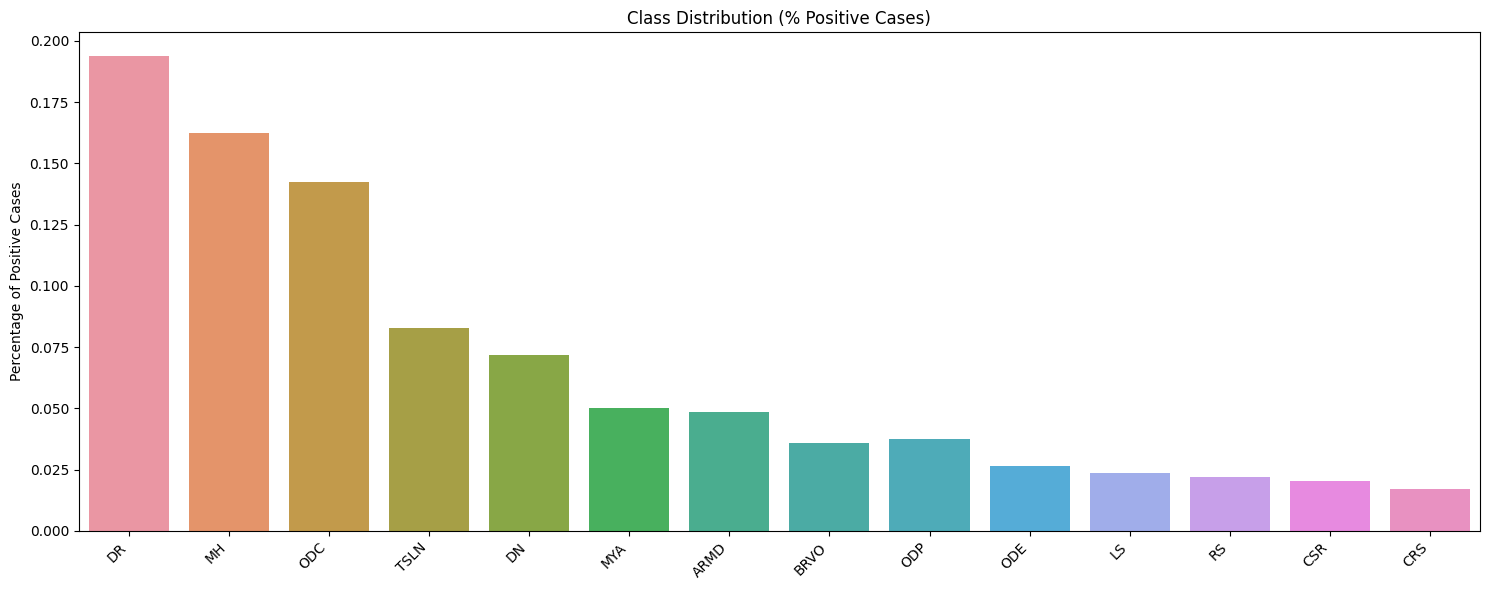


Calculating metrics...

Per-class metrics:

DR:
accuracy: 0.9453
precision: 0.9009
recall: 0.8065
f1: 0.8511
auc: 0.9829

MH:
accuracy: 0.9406
precision: 0.8173
recall: 0.8173
f1: 0.8173
auc: 0.9754

ODC:
accuracy: 0.8984
precision: 0.6857
recall: 0.5275
f1: 0.5963
auc: 0.9228

TSLN:
accuracy: 0.9422
precision: 0.6538
recall: 0.6415
f1: 0.6476
auc: 0.9625

DN:
accuracy: 0.9391
precision: 0.7059
recall: 0.2609
f1: 0.3810
auc: 0.8837

MYA:
accuracy: 0.9781
precision: 0.8214
recall: 0.7188
f1: 0.7667
auc: 0.9869

ARMD:
accuracy: 0.9672
precision: 0.6923
recall: 0.5806
f1: 0.6316
auc: 0.9550

BRVO:
accuracy: 0.9875
precision: 0.8947
recall: 0.7391
f1: 0.8095
auc: 0.9575

ODP:
accuracy: 0.9672
precision: 0.6154
recall: 0.3333
f1: 0.4324
auc: 0.8742

ODE:
accuracy: 0.9906
precision: 0.8667
recall: 0.7647
f1: 0.8125
auc: 0.9518

LS:
accuracy: 0.9797
precision: 0.7500
recall: 0.2000
f1: 0.3158
auc: 0.8685

RS:
accuracy: 0.9859
precision: 0.6667
recall: 0.7143
f1: 0.6897
auc: 0.9897

CSR:
accu

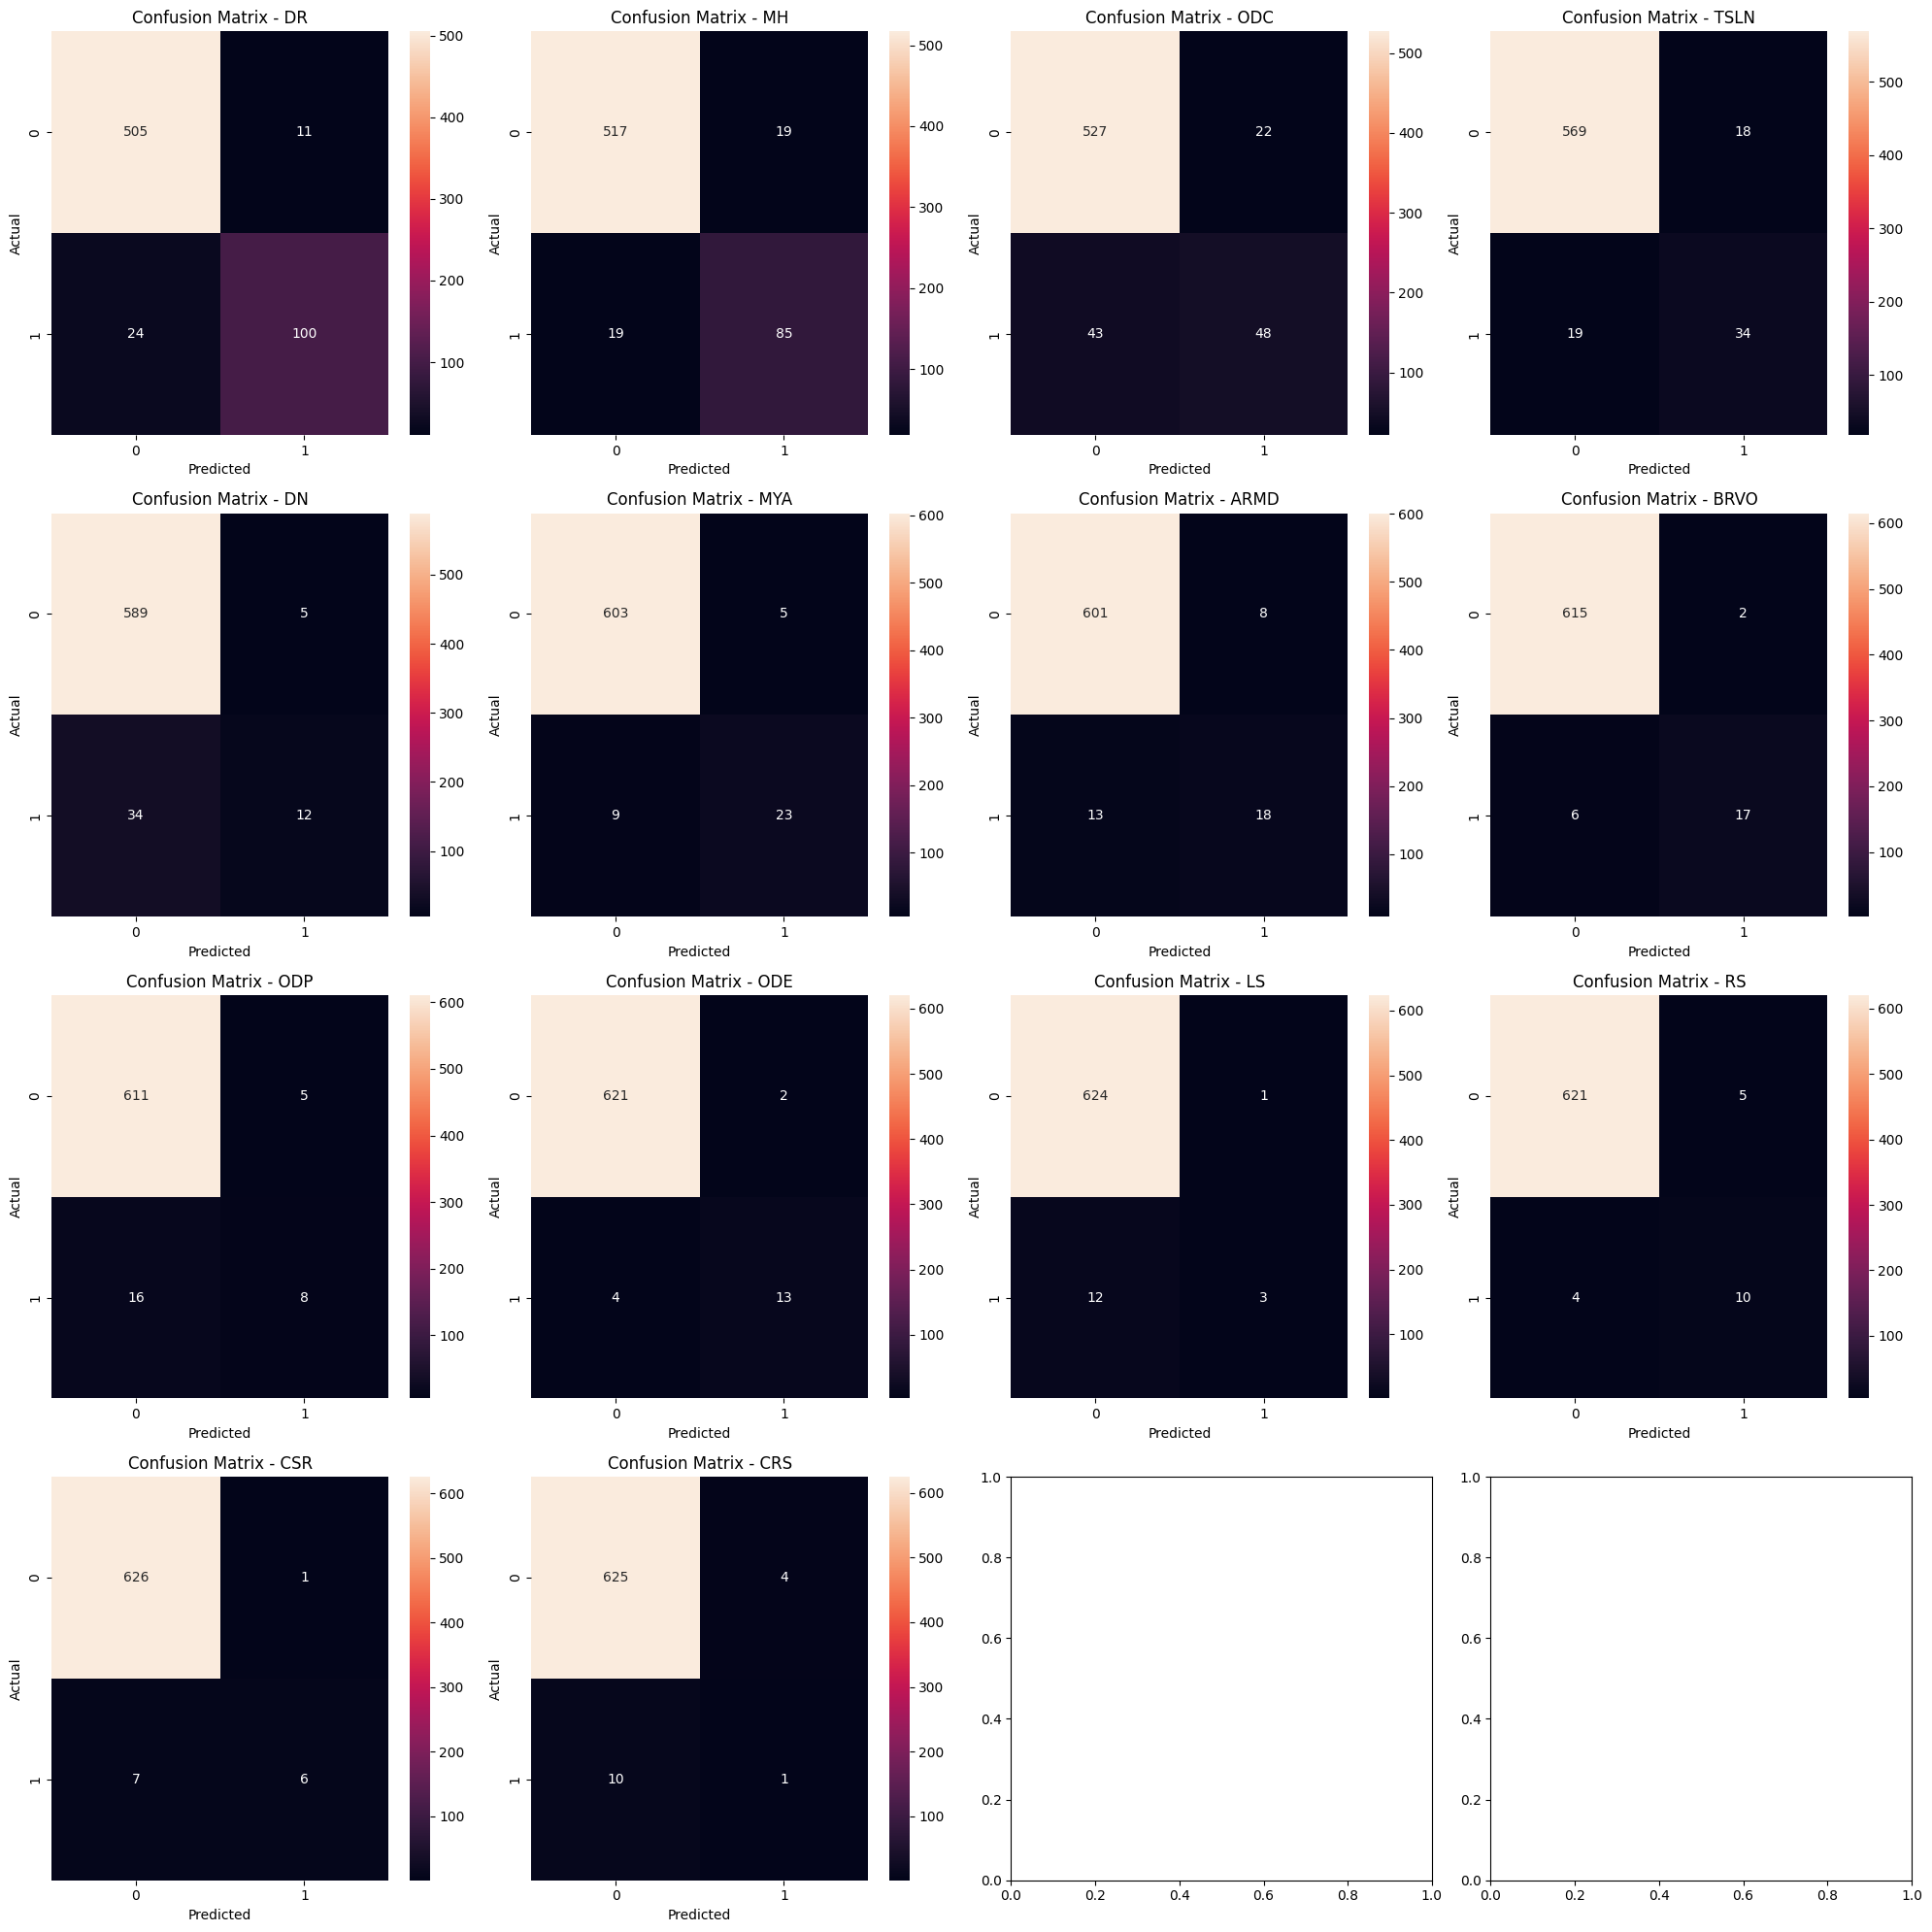


Plotting ROC curves...


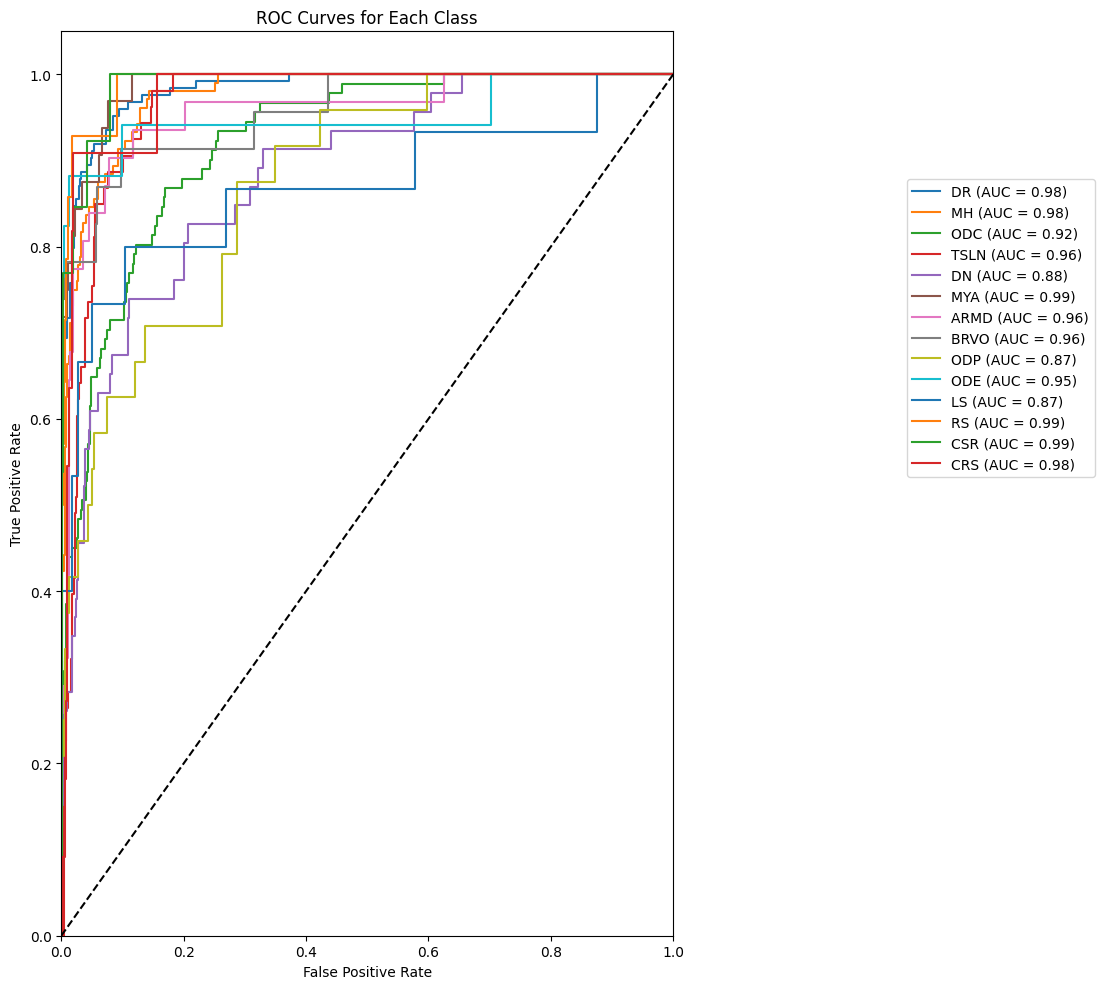


Visualizing sample predictions...


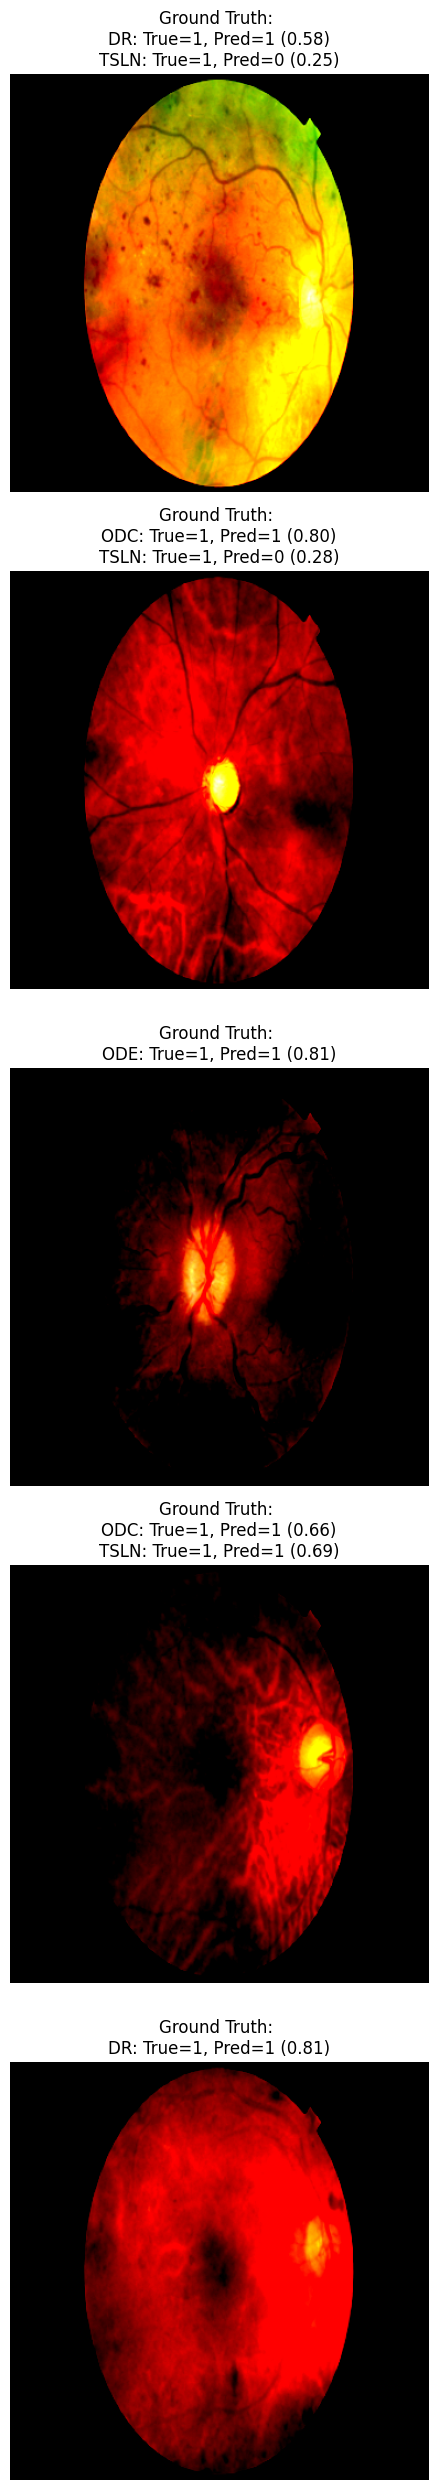


Metrics have been saved to 'evaluation_metrics.json'


In [22]:
evaluate()

In [ ]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.metrics import AUC
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.applications import EfficientNetB4
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import regularizers
from tensorflow.keras.losses import BinaryFocalCrossentropy
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.utils import to_categorical
from concurrent.futures import ThreadPoolExecutor

In [ ]:
#### print("Available GPUs:", tf.config.list_physical_devices('GPU'))

In [ ]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
            print("GPU Done!!")
    except RuntimeError as e:
        print(e)

In [ ]:
policy = tf.keras.mixed_precision.Policy('mixed_float16')
tf.keras.mixed_precision.set_global_policy(policy)

In [ ]:
!nvidia-smi

In [ ]:
# Set random seed for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

# Configuration
IMG_SIZE = (380, 380)  # EfficientNetB4 requires 380x380
BATCH_SIZE = 64
EPOCHS_PHASE1 = 15
EPOCHS_PHASE2 = 10
CLASS_NAMES = ['DR', 'MH', 'ODC', 'TSLN', 'DN', 'MYA', 'ARMD', 'BRVO', 'ODP', 'ODE', 'LS', 'RS', 'CSR', 'CRS']

# Paths
train_labels_path = "/kaggle/input/retinal-disease-classification/Training_Set/Training_Set/RFMiD_Training_Labels.csv"
val_labels_path = "/kaggle/input/retinal-disease-classification/Evaluation_Set/Evaluation_Set/RFMiD_Validation_Labels.csv"
test_labels_path = "/kaggle/input/retinal-disease-classification/Test_Set/Test_Set/RFMiD_Testing_Labels.csv"

In [ ]:
# Load and preprocess data
def load_and_preprocess_data():
    train_labels = pd.read_csv(train_labels_path)
    val_labels = pd.read_csv(val_labels_path)
    test_labels = pd.read_csv(test_labels_path)

    selected_diseases = CLASS_NAMES
    
    def process_df(df):
        selected_diseases = list(set(CLASS_NAMES) & set(df.columns))
        df = df[['ID', 'Disease_Risk'] + selected_diseases].copy()
        df['Disease_Risk'] = (df[selected_diseases].sum(axis=1) > 0).astype(int)
        return df

    return (
        process_df(train_labels),
        process_df(val_labels),
        process_df(test_labels)
    )

train_df, val_df, test_df = load_and_preprocess_data()

In [ ]:
# Enhanced Data Generator with Mixup
class AdvancedDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, img_dir, df, batch_size=32, img_size=IMG_SIZE, 
                 augment=False, shuffle=True, mixup_alpha=0.4, **kwargs):
        super().__init__(**kwargs) 
         
        self.img_dir = img_dir
        self.df = df
        self.batch_size = batch_size
        self.img_size = img_size
        self.augment = augment
        self.shuffle = shuffle
        self.mixup_alpha = mixup_alpha
        self.indices = np.arange(len(df))
        
        # Pre-load all image paths for faster access
        self.image_paths = [os.path.join(img_dir, f"{row['ID']}.png") for _, row in df.iterrows()]

        # Augmentation configurations
        self.augmenter = ImageDataGenerator(
            rotation_range=25,
            width_shift_range=0.2,
            height_shift_range=0.2,
            shear_range=0.2,
            zoom_range=0.2,
            horizontal_flip=True,
            vertical_flip=True,
            brightness_range=[0.8, 1.2]
        )

        # Set memory optimization flags
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.df) / self.batch_size))

    def __getitem__(self, index):
        batch_indices = self.indices[index*self.batch_size : (index+1)*self.batch_size]
        batch_df = self.df.iloc[batch_indices]

        # Use parallel processing for data loading
        with ThreadPoolExecutor(max_workers=4) as executor:
            results = list(executor.map(self._load_single_item, batch_indices))

        X = np.stack([r[0] for r in results])
        y = np.stack([r[1] for r in results])

        # Apply Mixup using vectorized operations
        if self.augment and self.mixup_alpha > 0:
            X, y = self._apply_mixup(X, y)
            
        return X, y        
        # # Load images and labels
        # X, y = self._load_data(batch_df)
        
        # # Apply Mixup
        # if self.augment and self.mixup_alpha > 0:
        #     X, y = self._apply_mixup(X, y)
            
        # return X, y

    def _load_single_item(self, idx):
        row = self.df.iloc[idx]
        img = load_img(self.image_paths[idx], target_size=self.img_size)
        img_array = img_to_array(img)
        
        if self.augment and row['Disease_Risk'] == 1:
            img_array = self.augmenter.random_transform(img_array)
            
        return preprocess_input(img_array), row[CLASS_NAMES].values.astype(np.float32)
    
    def _apply_mixup(self, X, y):
        lam = np.clip(np.random.beta(self.mixup_alpha, self.mixup_alpha), 0.2, 0.8)
        rand_index = np.random.permutation(len(X))
        
        # Vectorized operations
        mixed_X = lam * X + (1 - lam) * X[rand_index]
        mixed_y = lam * y + (1 - lam) * y[rand_index]
        return mixed_X, mixed_y

    # def on_epoch_end(self):
    #     if self.shuffle:
    #         np.random.shuffle(self.indices)

    # def _load_data(self, batch_df):
    #     X = np.empty((len(batch_df), *self.img_size, 3))
    #     y = np.empty((len(batch_df), len(CLASS_NAMES)))   # Disease_Risk + diseases
        
    #     for i, (_, row) in enumerate(batch_df.iterrows()):
    #         img_path = os.path.join(self.img_dir, f"{row['ID']}.png")
    #         img = load_img(img_path, target_size=self.img_size)
    #         img_array = img_to_array(img)
            
    #         # Apply augmentation only to diseased samples
    #         if self.augment and row['Disease_Risk'] == 1:
    #             img_array = self.augmenter.random_transform(img_array)
                
    #         X[i] = preprocess_input(img_array)  # EfficientNet preprocessing
    #         y[i] = row[CLASS_NAMES].values
            
    #     return X, y.astype(np.float32)

    # def _apply_mixup(self, X, y):
    #     lam = np.clip(np.random.beta(self.mixup_alpha, self.mixup_alpha), 0.2, 0.8)
    #     rand_index = np.random.permutation(len(X))
        
    #     mixed_X = lam * X + (1 - lam) * X[rand_index]
    #     mixed_y = lam * y + (1 - lam) * y[rand_index]
    #     return mixed_X, mixed_y

In [ ]:
# Create data generators
train_gen = AdvancedDataGenerator(
    "/kaggle/input/retinal-disease-classification/Training_Set/Training_Set/Training",
    train_df,
    batch_size=BATCH_SIZE,
    augment=True,
    mixup_alpha=0.4
)

val_gen = AdvancedDataGenerator(
    "/kaggle/input/retinal-disease-classification/Evaluation_Set/Evaluation_Set/Validation",
    val_df,
    batch_size=BATCH_SIZE
)

test_gen = AdvancedDataGenerator(
    "/kaggle/input/retinal-disease-classification/Test_Set/Test_Set/Test",
    test_df,
    batch_size=BATCH_SIZE
)

def generator_wrapper(generator):
    for X, y in generator:
        yield X, y

# train_dataset = tf.data.Dataset.from_generator(
#     lambda: generator_wrapper(train_gen),
#     output_signature=(
#         tf.TensorSpec(shape=(None, *IMG_SIZE, 3), dtype=tf.float32),
#         tf.TensorSpec(shape=(None, len(CLASS_NAMES)), dtype=tf.float32)
#     )
# ).prefetch(tf.data.AUTOTUNE)

train_dataset = tf.data.Dataset.from_generator(
    lambda: generator_wrapper(train_gen),
    output_signature=(
        tf.TensorSpec(shape=(None, *IMG_SIZE, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(None, len(CLASS_NAMES)), dtype=tf.float32)
    )
).prefetch(tf.data.AUTOTUNE).cache().shuffle(buffer_size=1000)


In [ ]:
X_batch, y_batch = train_gen[0]
print("Shape of X_batch:", X_batch.shape)  # Should be (batch_size, 380, 380, 3)
print("Shape of y_batch:", y_batch.shape)  # Should be (batch_size, 14)

In [ ]:
# Calculate class weights
def calculate_class_weights(df):
    weights = {}
    for idx, disease in enumerate(['Disease_Risk'] + CLASS_NAMES):
        cls_weights = compute_class_weight(
            'balanced',
            classes=np.array([0, 1]),
            y=df[disease]
        )
        weights[idx] = {0: cls_weights[0], 1: cls_weights[1]}
    return weights

class_weights = calculate_class_weights(train_df)
class_weights = {idx: weights[1] for idx, weights in class_weights.items()}

In [ ]:
# Build Model
def build_model():
    base_model = EfficientNetB4(
        weights='imagenet',
        include_top=False,
        input_shape=(*IMG_SIZE, 3)
    )
    base_model.trainable = False  # Freeze initially

    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        BatchNormalization(),
        Dropout(0.5),
        Dense(512, activation='swish', kernel_regularizer=regularizers.l2(1e-4)),
        BatchNormalization(),
        Dropout(0.5),
        Dense(256, activation='swish'),
        Dense(len(CLASS_NAMES), activation='sigmoid')  # Disease_Risk + diseases
    ])
    
    return model

In [ ]:
def focal_loss(alpha=0.25, gamma=2.0):
    def loss_fn(y_true, y_pred):
        # Cast to float32
        y_true = tf.cast(y_true, tf.float32)
        y_pred = tf.cast(y_pred, tf.float32)
        
        # Compute element-wise binary crossentropy using Keras backend.
        ce = tf.keras.backend.binary_crossentropy(y_true, y_pred)  
        # ce now has shape (batch_size, num_classes)
        
        # Compute p_t element-wise
        p_t = y_true * y_pred + (1 - y_true) * (1 - y_pred)
        
        # Compute alpha factor element-wise
        alpha_factor = y_true * alpha + (1 - y_true) * (1 - alpha)
        
        # Compute modulating factor element-wise
        modulating_factor = tf.pow(1.0 - p_t, gamma)
        
        # Final loss element-wise
        loss = alpha_factor * modulating_factor * ce
        return loss  # Optionally, you can reduce_mean over the batch or last axis.
    
    return loss_fn


In [ ]:
sample_y_true = tf.convert_to_tensor(y_batch[:5], dtype=tf.float32)  # (5, 14)
sample_y_pred = tf.random.uniform(sample_y_true.shape, 0, 1)           # (5, 14)
loss_fn = focal_loss(alpha=0.25, gamma=2.0)
print(loss_fn(sample_y_true, sample_y_pred))


In [ ]:
print("y_true shape:", sample_y_true.shape)
print("y_pred shape:", sample_y_pred.shape)

In [ ]:
# Two-Phase Training
model = build_model()

# Phase 1: Train head
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss=focal_loss(gamma=2.0, alpha=0.25),
    metrics=[AUC(name='auc', multi_label=True)]
)

phase1_callbacks = [
    EarlyStopping(patience=3, monitor='val_auc', mode='max', verbose=1),
    ModelCheckpoint('phase1_best.keras', save_best_only=True),
    ReduceLROnPlateau(factor=0.5, patience=2)
]

history_phase1 = model.fit(
    train_dataset,
    validation_data=val_gen,
    epochs=EPOCHS_PHASE1,
    callbacks=phase1_callbacks,
    # workers=4,  # Increase as needed
    # use_multiprocessing=True
)

In [ ]:
# Phase 2: Fine-tune
model = tf.keras.models.load_model('phase1_best.keras', custom_objects={'loss_fn': focal_loss()}) # Load best weights from phase 1
model.layers[0].trainable = True  # Unfreeze base model

# Set last 150 layers trainable
for layer in model.layers[0].layers[-150:]:
    layer.trainable = True

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss=focal_loss(gamma=2.0, alpha=0.25),
    metrics=[AUC(name='auc', multi_label=True)]
)

phase2_callbacks = [
    EarlyStopping(patience=2, monitor='val_auc', mode='max', verbose=1),
    ModelCheckpoint('final_model.keras', save_best_only=True),
    ReduceLROnPlateau(factor=0.2, patience=1)
]

history_phase2 = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS_PHASE2,
    callbacks=phase2_callbacks
)

In [ ]:
# Evaluation with Test-Time Augmentation
def evaluate_with_tta(model, generator, n_tta=5):
    y_true, y_pred = [], []
    # tta_preds = []
    
    for i in range(len(generator)):
        X, y = generator[i]
        batch_preds = np.zeros_like(y)
        
        for _ in range(n_tta):
            # Create augmented versions
            aug_X = np.array([generator.augmenter.random_transform(img) for img in X])
            batch_preds += model.predict(aug_X)
            
        # Average predictions
        batch_preds /= n_tta  # Average predictions
        y_true.append(y)
        y_pred.append(batch_preds)
        # avg_pred = np.mean(batch_preds, axis=0)
        # tta_preds.append(avg_pred)
        # y_true.append(y)
        
    return np.vstack(y_true), np.vstack(y_pred)

model = tf.keras.models.load_model('final_model.keras', custom_objects={'loss_fn': focal_loss()})
y_true, y_pred = evaluate_with_tta(model, test_gen)

In [ ]:
# Generate reports
print("Classification Report:")
print(classification_report(
    y_true[:, 1:],  # Skip Disease_Risk
    (y_pred[:, 1:] > 0.5).astype(int),
    target_names=CLASS_NAMES
))

print("\nConfusion Matrices:")
for idx, disease in enumerate(CLASS_NAMES):
    cm = confusion_matrix(y_true[:, idx+1], (y_pred[:, idx+1] > 0.5).astype(int))
    plt.figure()
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"{disease} Confusion Matrix")
    plt.show()

In [ ]:
# Plot training history
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history_phase1.history['auc'], label='Phase1 Train')
plt.plot(history_phase1.history['val_auc'], label='Phase1 Val')
plt.plot(np.arange(EPOCHS_PHASE1, EPOCHS_PHASE1+len(history_phase2.history['auc'])), 
         history_phase2.history['auc'], label='Phase2 Train')
plt.plot(np.arange(EPOCHS_PHASE1, EPOCHS_PHASE1+len(history_phase2.history['val_auc'])), 
         history_phase2.history['val_auc'], label='Phase2 Val')
plt.title('AUC History')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_phase1.history['loss'], label='Phase1 Train')
plt.plot(history_phase1.history['val_loss'], label='Phase1 Val')
plt.plot(np.arange(EPOCHS_PHASE1, EPOCHS_PHASE1+len(history_phase2.history['loss'])), 
         history_phase2.history['loss'], label='Phase2 Train')
plt.plot(np.arange(EPOCHS_PHASE1, EPOCHS_PHASE1+len(history_phase2.history['val_loss'])), 
         history_phase2.history['val_loss'], label='Phase2 Val')
plt.title('Loss History')
plt.legend()
plt.show()